# Modelo preditivo de sobreviventes do acidente do navio Titanic

In [49]:
#importando bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as mn
import seaborn as sns
import matplotlib.style as style
from sklearn.metrics import (accuracy_score, precision_score,recall_score, f1_score,
                             roc_auc_score, roc_curve, classification_report,
                             confusion_matrix, plot_confusion_matrix)
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from sklearn import model_selection
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as metrics

# setting up plot style 
style.use('seaborn-poster')
style.use('fivethirtyeight')
%matplotlib inline


In [2]:
#import dataset
url = ("http://biostat.mc.vanderbilt.edu/wiki/pub/Main/DataSets/titanic3.xls")

In [3]:
df = pd.read_excel(url)
orig_df = df
df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [4]:
df.shape

(1309, 14)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     1309 non-null   int64  
 1   survived   1309 non-null   int64  
 2   name       1309 non-null   object 
 3   sex        1309 non-null   object 
 4   age        1046 non-null   float64
 5   sibsp      1309 non-null   int64  
 6   parch      1309 non-null   int64  
 7   ticket     1309 non-null   object 
 8   fare       1308 non-null   float64
 9   cabin      295 non-null    object 
 10  embarked   1307 non-null   object 
 11  boat       486 non-null    object 
 12  body       121 non-null    float64
 13  home.dest  745 non-null    object 
dtypes: float64(3), int64(4), object(7)
memory usage: 143.3+ KB


In [6]:
df.describe()

,pclass,survived,age,sibsp,parch,fare,body
count,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,121.000000
mean,2.294882,0.381971,29.881135,0.498854,0.385027,33.295479,160.809917
std,0.837836,0.486055,14.413500,1.041658,0.865560,51.758668,97.696922
min,1.000000,0.000000,0.166700,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,21.000000,0.000000,0.000000,7.895800,72.000000
50%,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200,155.000000
75%,3.000000,1.000000,39.000000,1.000000,0.000000,31.275000,256.000000
max,3.000000,1.000000,80.000000,8.000000,9.000000,512.329200,328.000000


## Data Cleaning

Dicionário das colunas:

- **pclass**: classe do passageiro (1 = primeira, 2 = segunda, 3 = terceira)
- **survived**: sobreviveu (0 = não, 1 = sim)
- **name**: nome
- **sex**: sexo
- **age**: idade
- **sibsp**: número de irmãos/esposa(o) a bordo
- **parch**: número de pais/filhos a bordo
- **ticket**: número da passagem
- **fare**: preço da passagem
- **cabin**: cabine
- **embarked**: (local em que o passageiro embarcou C = Cherbourg, Q = Queenstown, S = Southampton)
- **boat**: bote salva-vidas
- **body**: número de identificação do corpo
- **home.dest**: lar/destino

#### Missing values

<AxesSubplot:>

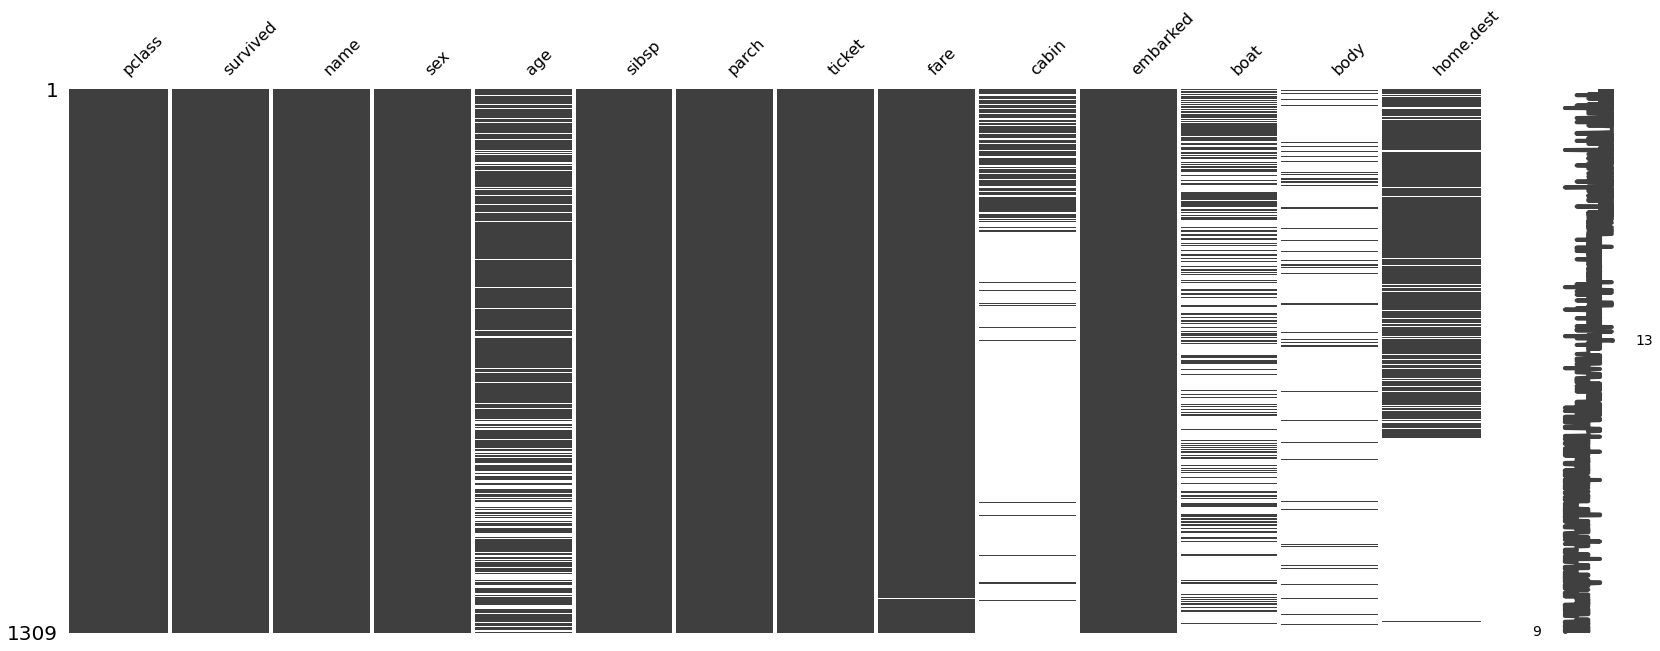

In [7]:
mn.matrix(df)

In [8]:
df.isnull().sum()

pclass          0
survived        0
name            0
sex             0
age           263
sibsp           0
parch           0
ticket          0
fare            1
cabin        1014
embarked        2
boat          823
body         1188
home.dest     564
dtype: int64

Vamos excluir as colunas: ticket, name, home.dest, boat, body e cabin por não fornecerem informações relevantes diretas para ocndição de sobrivência dos passageiros, exceto as colunas `body` e `boat`. Estas contém informações 'vazadas', ou seja, identificam se o passageiro sobreviveu ou não. 

Não podemos utilizá-las em nosso modelo uma vez que esta é justamente nossa variável independente, nosso alvo: queremos prever se o passageiro vai sobreviver ou não.

In [9]:
#dropando colunas desnecessárias 
cols = ['name', 'ticket', 'home.dest','boat', 'body', 'cabin']
df.drop(columns = cols, axis = 1, inplace = True)
df.columns

Index(['pclass', 'survived', 'sex', 'age', 'sibsp', 'parch', 'fare',
       'embarked'],
      dtype='object')

Vamos preencher os valroes nulos da coluna `age`

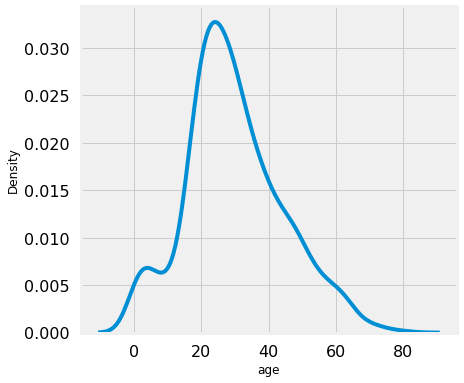

In [10]:
#verificando a distribuição:
plt.figure(figsize=(6,6))
sns.kdeplot(df['age'])
plt.show()

A distribuição dos valores se assemelha com uma distribuição normal. Portanto vamos preencher os valores nulos com a média da idade. 

<AxesSubplot:>

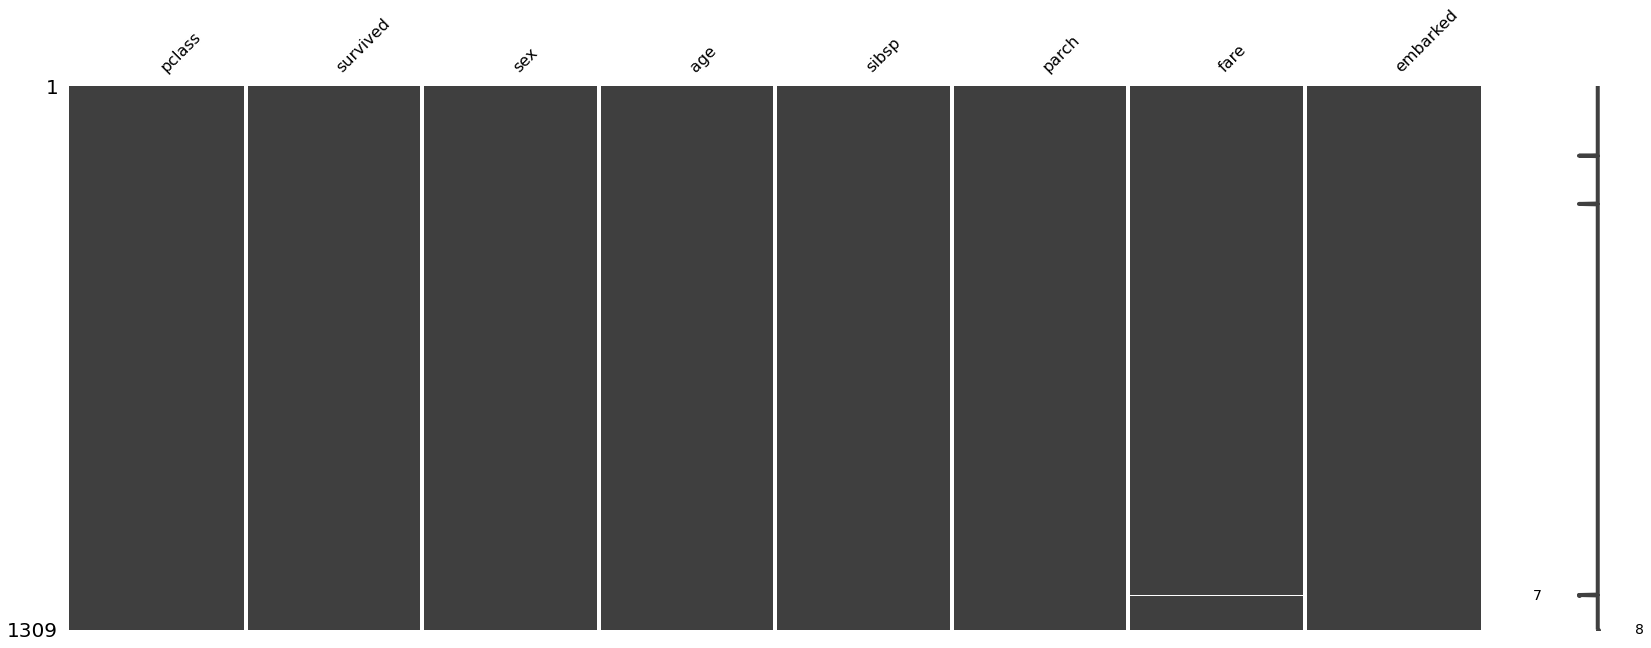

In [11]:
df['age'] = df['age'].fillna(df['age'].mean())
mn.matrix(df)

In [12]:
df.isnull().sum()

pclass      0
survived    0
sex         0
age         0
sibsp       0
parch       0
fare        1
embarked    2
dtype: int64

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pclass    1309 non-null   int64  
 1   survived  1309 non-null   int64  
 2   sex       1309 non-null   object 
 3   age       1309 non-null   float64
 4   sibsp     1309 non-null   int64  
 5   parch     1309 non-null   int64  
 6   fare      1308 non-null   float64
 7   embarked  1307 non-null   object 
dtypes: float64(2), int64(4), object(2)
memory usage: 81.9+ KB


A coluna `fare` possui um valor nulo. Vamos descartá-lo.


In [14]:
df.dropna(subset=['fare'], inplace = True)

In [15]:
df.isnull().sum()

pclass      0
survived    0
sex         0
age         0
sibsp       0
parch       0
fare        0
embarked    2
dtype: int64

Vamos preencher os valores nulos da coluna `embarked` com `no_info`

In [16]:
df['embarked'].fillna(value = 'no_info', inplace = True)

In [17]:
df.embarked.value_counts()

S          913
C          270
Q          123
no_info      2
Name: embarked, dtype: int64

### Pre processing

In [18]:
df.dtypes

pclass        int64
survived      int64
sex          object
age         float64
sibsp         int64
parch         int64
fare        float64
embarked     object
dtype: object

In [19]:
#aplicando dummies nas colunas categóricas

df = pd.get_dummies(df,drop_first = True)
df.dtypes

pclass                int64
survived              int64
age                 float64
sibsp                 int64
parch                 int64
fare                float64
sex_male              uint8
embarked_Q            uint8
embarked_S            uint8
embarked_no_info      uint8
dtype: object

In [20]:
# definindo as features e a label
X = df.drop(columns = 'survived')
y = df.survived

In [21]:
X

,pclass,age,sibsp,parch,fare,sex_male,embarked_Q,embarked_S,embarked_no_info
0,1,29.000000,0,0,211.3375,0,0,1,0
1,1,0.916700,1,2,151.5500,1,0,1,0
2,1,2.000000,1,2,151.5500,0,0,1,0
3,1,30.000000,1,2,151.5500,1,0,1,0
4,1,25.000000,1,2,151.5500,0,0,1,0
...,...,...,...,...,...,...,...,...,...
1304,3,14.500000,1,0,14.4542,0,0,0,0
1305,3,29.881135,1,0,14.4542,0,0,0,0
1306,3,26.500000,0,0,7.2250,1,0,0,0
1307,3,27.000000,0,0,7.2250,1,0,0,0


In [22]:
y.head()

0    1
1    1
2    0
3    0
4    0
Name: survived, dtype: int64

#### Separando base de treino e teste

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

#### Normalize

In [24]:
sc = StandardScaler()
X_train.iloc[:,0:5] = sc.fit_transform(X_train.iloc[:,0:5])
X_test.iloc[:,0:5] = sc.fit_transform(X_test.iloc[:,0:5])

C:\Users\Fabio\anaconda3\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
C:\Users\Fabio\anaconda3\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


Check:

In [25]:
X_train.head()

,pclass,age,sibsp,parch,fare,sex_male,embarked_Q,embarked_S,embarked_no_info
770,0.841045,0.505365,-0.498108,-0.446149,-0.503680,1,0,1,0
543,-0.354244,0.505365,-0.498108,-0.446149,-0.440927,1,0,1,0
289,-1.549533,-0.924037,-0.498108,1.922744,0.894261,0,0,1,0
10,-1.549533,1.378889,0.470332,-0.446149,3.749515,1,0,0,0
147,-1.549533,0.019459,-0.498108,-0.446149,0.175017,1,0,1,0


In [26]:
X_test.head()

,pclass,age,sibsp,parch,fare,sex_male,embarked_Q,embarked_S,embarked_no_info
1013,0.848171,-0.062335,-0.408477,-0.444431,-0.486774,0,0,1,0
1048,0.848171,-2.152290,-0.408477,1.672676,-0.337514,0,0,0,0
695,0.848171,-0.922101,-0.408477,-0.444431,-0.490088,0,1,0,0
736,0.848171,2.044823,-0.408477,-0.444431,-0.502298,1,0,1,0
723,0.848171,0.018631,-0.408477,-0.444431,-0.492920,1,1,0,0


## Building Models

### Dummy Classifier (base model)

In [27]:
#create the classifier
bm = DummyClassifier(strategy = 'uniform', random_state = 42)

#training
bm.fit(X_train, y_train)

#predict
bm_pred = bm.predict(X_test)

In [28]:
# Accuracy
accuracy_score(y_test, bm_pred)

0.4770992366412214

In [29]:
#precision
precision_score(y_test, bm_pred)

0.3798449612403101

Como iremos utilizar validação cruzada k-fold, e a base não é muito grande, alimentaremos todos os modelos com dataset inteiro

In [33]:
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

In [36]:
for model in [
    DummyClassifier,
    LogisticRegression,
    DecisionTreeClassifier,
    KNeighborsClassifier,
    GaussianNB,
    SVC,
    RandomForestClassifier,
    xgboost.XGBClassifier]:
    cls = model()
    kfold = model_selection.KFold(n_splits = 10)
    s = model_selection.cross_val_score(cls, X, y, scoring = "roc_auc", cv=kfold)
    print(f"{model.__name__:22} AUC:"
          f"{s.mean():.3f} STD: {s.std():.2f}")    

C:\Users\Fabio\anaconda3\lib\site-packages\sklearn\dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
C:\Users\Fabio\anaconda3\lib\site-packages\sklearn\dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
C:\Users\Fabio\anaconda3\lib\site-packages\sklearn\dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
C:\Users\Fabio\anaconda3\lib\site-packages\sklearn\dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
C:\Users\Fabio\anaconda3\lib\site-packages\sklearn\dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior i

DummyClassifier        AUC:0.489 STD: 0.05
LogisticRegression     AUC:0.841 STD: 0.03
DecisionTreeClassifier AUC:0.724 STD: 0.04
KNeighborsClassifier   AUC:0.826 STD: 0.04
GaussianNB             AUC:0.820 STD: 0.04
SVC                    AUC:0.834 STD: 0.04
RandomForestClassifier AUC:0.842 STD: 0.03
XGBClassifier          AUC:0.846 STD: 0.03


O melhor modelo foi o XGBOOST. Vamos aplicar "hyperparameter tunning" para tentar melhorar nossa métrica.

In [38]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}

In [40]:
gsearch1 = GridSearchCV(estimator = xgboost.XGBClassifier( learning_rate =0.1, n_estimators=140, 
                        gamma=0, subsample=0.8, colsample_bytree=0.8, objective= 'binary:logistic',
                                                  nthread=4, scale_pos_weight=1), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=-1, cv=kfold)

In [41]:
gsearch1.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, gamma=0, gpu_id=None,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=140, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=1, subsample=0.8,
 

In [42]:
gsearch1.score(X_train, y_train)

0.949382610320451

In [43]:
gsearch1.score(X_test, y_test)

0.8584905660377358

In [46]:
#AUC
xgb_prob = gsearch1.predict_proba(X_test)
xgb_prob = xgb_prob[:, 1]

xgb_auc = roc_auc_score(y_test, xgb_prob)

print('XGBoost Test AUC = %.3f' % (xgb_auc))

XGBoost Test AUC = 0.858


Text(0.5, 0, 'False Positive Rate')

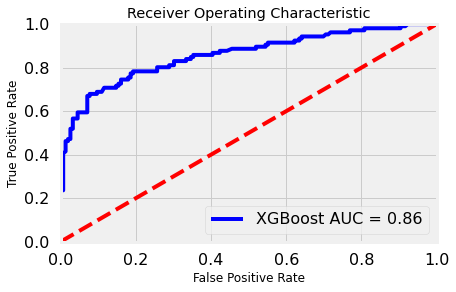

In [50]:
# AUC plot
xgb_fpr, xgb_tpr, threshold = roc_curve(y_test, xgb_prob)
xgb_roc_auc = metrics.auc(xgb_fpr, xgb_tpr)

# method I: plt
plt.title('Receiver Operating Characteristic')
plt.plot(xgb_fpr, xgb_tpr, 'b', label = 'XGBoost AUC = %0.2f' % xgb_roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')